In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math, copy

#### Dataset

In [2]:
X_train = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_train = np.array([0, 0, 0, 1, 1, 1])

#### Lab utils routines

In [13]:
def plot_data(X, y, ax, pos_label="y=1", neg_label="y=0", s=80, loc='best' ):
    """ plots logistic data with two axis """
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0
    pos = pos.reshape(-1,)  #work with 1D or 1D y vectors
    neg = neg.reshape(-1,)

    # Plot examples
    ax.scatter(X[pos, 0], X[pos, 1], marker='x', s=s, c = 'red', label=pos_label)
    ax.scatter(X[neg, 0], X[neg, 1], marker='o', s=s, label=neg_label, facecolors='none', edgecolors="blue", lw=3)
    ax.legend(loc=loc)

    ax.figure.canvas.toolbar_visible = False
    ax.figure.canvas.header_visible = False
    ax.figure.canvas.footer_visible = False


def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    z = np.clip( z, -500, 500 )           # protect against overflow
    g = 1.0/(1.0+np.exp(-z))

    return g


def compute_cost_logistic(X, y, w, b, lambda_=0, safe=False):
    """
    Computes cost using logistic loss, non-matrix version

    Args:
      X (ndarray): Shape (m,n)  matrix of examples with n features
      y (ndarray): Shape (m,)   target values
      w (ndarray): Shape (n,)   parameters for prediction
      b (scalar):               parameter  for prediction
      lambda_ : (scalar, float) Controls amount of regularization, 0 = no regularization
      safe : (boolean)          True-selects under/overflow safe algorithm
    Returns:
      cost (scalar): cost
    """

    m,n = X.shape
    cost = 0.0
    for i in range(m):
        z_i    = np.dot(X[i],w) + b                                             #(n,)(n,) or (n,) ()
        if safe:  #avoids overflows
            cost += -(y[i] * z_i ) + log_1pexp(z_i)
        else:
            f_wb_i = sigmoid(z_i)                                                   #(n,)
            cost  += -y[i] * np.log(f_wb_i) - (1 - y[i]) * np.log(1 - f_wb_i)       # scalar
    cost = cost/m

    reg_cost = 0
    if lambda_ != 0:
        for j in range(n):
            reg_cost += (w[j]**2)                                               # scalar
        reg_cost = (lambda_/(2*m))*reg_cost

    return cost + reg_cost


#### Plot

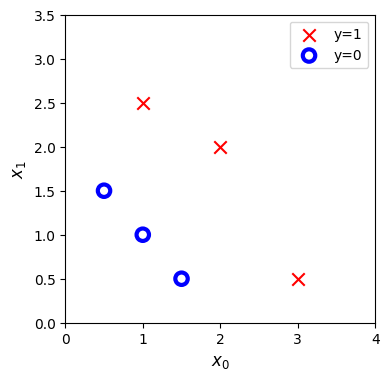

In [7]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_data(X_train, y_train, ax)

ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_xlabel('$x_0$', fontsize=12)
plt.show()

## Logistic Gradient Descent
Recall the gradient descent algorithm utilizes the gradient calculation:
$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1} \\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace
\end{align*}$$

Where each iteration performs simultaneous updates on $w_j$ for all $j$, where
$$\begin{align*}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3} 
\end{align*}$$

* m is the number of training examples in the data set      
* $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target
* For a logistic regression model  
    $z = \mathbf{w} \cdot \mathbf{x} + b$  
    $f_{\mathbf{w},b}(x) = g(z)$  
    where $g(z)$ is the sigmoid function:  
    $g(z) = \frac{1}{1+e^{-z}}$   
    


### Gradient Descent Implementation
The gradient descent algorithm implementation has two components: 
- The loop implementing equation (1) above. This is `gradient_descent` below and is generally provided to you in optional and practice labs.
- The calculation of the current gradient, equations (2,3) above. This is `compute_gradient_logistic` below. You will be asked to implement this week's practice lab.

#### Calculating the Gradient, Code Description
Implements equation (2),(3) above for all $w_j$ and $b$.
There are many ways to implement this. Outlined below is this:
- initialize variables to accumulate `dj_dw` and `dj_db`
- for each example
    - calculate the error for that example $g(\mathbf{w} \cdot \mathbf{x}^{(i)} + b) - \mathbf{y}^{(i)}$
    - for each input value $x_{j}^{(i)}$ in this example,  
        - multiply the error by the input  $x_{j}^{(i)}$, and add to the corresponding element of `dj_dw`. (equation 2 above)
    - add the error to `dj_db` (equation 3 above)

- divide `dj_db` and `dj_dw` by total number of examples (m)
- note that $\mathbf{x}^{(i)}$ in numpy `X[i,:]` or `X[i]`  and $x_{j}^{(i)}$ is `X[i,j]`

In [10]:
def compute_gradient_logistic(X, y, w, b): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))                           #(n,)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar
        
    return dj_db, dj_dw  

In [11]:
X_tmp = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_tmp = np.array([0, 0, 0, 1, 1, 1])
w_tmp = np.array([2.,3.])
b_tmp = 1.
dj_db_tmp, dj_dw_tmp = compute_gradient_logistic(X_tmp, y_tmp, w_tmp, b_tmp)
print(f"dj_db: {dj_db_tmp}" )
print(f"dj_dw: {dj_dw_tmp.tolist()}" )

dj_db: 0.49861806546328574
dj_dw: [0.498333393278696, 0.49883942983996693]


**Expected output**
``` 
dj_db: 0.49861806546328574
dj_dw: [0.498333393278696, 0.49883942983996693]
```

#### Gradient Descent Code 
The code implementing equation (1) above is implemented below. Take a moment to locate and compare the functions in the routine to the equations above.

In [15]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_logistic(X, y, w, b) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w, b, J_history         #return final w,b and J history for graphing


In [16]:
w_tmp  = np.zeros_like(X_train[0])
b_tmp  = 0.
alph = 0.1
iters = 10000

w_out, b_out, _ = gradient_descent(X_train, y_train, w_tmp, b_tmp, alph, iters) 
print(f"\nupdated parameters: w:{w_out}, b:{b_out}")

Iteration    0: Cost 0.684610468560574   
Iteration 1000: Cost 0.1590977666870457   
Iteration 2000: Cost 0.08460064176930078   
Iteration 3000: Cost 0.05705327279402531   
Iteration 4000: Cost 0.04290759421682   
Iteration 5000: Cost 0.03433847729884557   
Iteration 6000: Cost 0.02860379802212006   
Iteration 7000: Cost 0.02450156960879306   
Iteration 8000: Cost 0.02142370332569295   
Iteration 9000: Cost 0.019030137124109114   

updated parameters: w:[5.28123029 5.07815608], b:-14.222409982019837


#### Results of gradient descent

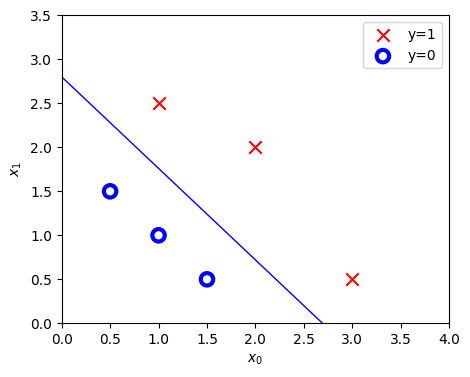

In [19]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
# plot the probability 
# plt_prob(ax, w_out, b_out)

# Plot the original data
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_0$')   
ax.axis([0, 4, 0, 3.5])
plot_data(X_train,y_train,ax)

# Plot the decision boundary
x0 = -b_out/w_out[0]
x1 = -b_out/w_out[1]
ax.plot([0,x0],[x1,0], c="blue", lw=1)
plt.show()